In [25]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.nn.functional import cross_entropy

import pickle

import torch.nn as nn
import torch.nn.functional as F

from sklearn.model_selection import train_test_split

import ffnn

In [30]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)

data = torch.tensor(train_dataset.data)
targets = torch.tensor(train_dataset.targets)

perm = torch.randperm(28*28)
data_permuted = data.view(-1, 28*28)[:, perm].view(-1, 28, 28)

/var/folders/cf/x33nxtlj1rzbqn7mh62k2v9c0000gn/T/ipykernel_244/3382429931.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(train_dataset.data)
/var/folders/cf/x33nxtlj1rzbqn7mh62k2v9c0000gn/T/ipykernel_244/3382429931.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(train_dataset.targets)


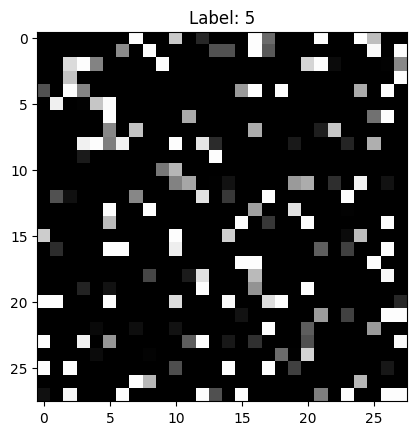

In [31]:
img, label = data_permuted[0], targets[0]

if len(img.shape) > 2 and img.shape[0] == 1:
    img = img.squeeze(0)

# Display the image
plt.imshow(img, cmap='gray')
plt.title(f'Label: {label}')
plt.show()

In [32]:
permuted_datasets = []
for i in range(2):
  data = torch.tensor(train_dataset.data)
  targets = torch.tensor(train_dataset.targets)

  perm = torch.randperm(28*28)
  
  data_permuted = data.view(-1, 28*28)[:, perm].view(-1, 28, 28)
  permuted_datasets.append((data_permuted, targets))

/var/folders/cf/x33nxtlj1rzbqn7mh62k2v9c0000gn/T/ipykernel_244/3177233283.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(train_dataset.data)
/var/folders/cf/x33nxtlj1rzbqn7mh62k2v9c0000gn/T/ipykernel_244/3177233283.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(train_dataset.targets)


In [13]:
permuted_datasets[3][1][2]
for batch_idx, (x,y) in enumerate(permuted_datasets):
  print(y,x)

# list of datasets, which are tuples (data, targets)

tensor([5, 0, 4,  ..., 5, 6, 8]) tensor([[[240,   0,   0,  ...,   0,   0,   0],
         [136,  46,   0,  ...,   0,   0, 253],
         [253,   0,   0,  ...,   0,   0,   0],
         ...,
         [  0, 253,   0,  ...,   0,   0,   0],
         [  0,   0,   0,  ...,   0,   0,   0],
         [253,   0,   0,  ...,   0,   0,   0]],

        [[  0, 246,  85,  ...,   0,   0,   0],
         [252,   0,   0,  ...,   0,   0, 253],
         [238,   0,   0,  ...,   0,   0,   0],
         ...,
         [  0,   0,   0,  ...,   0,   0,   0],
         [  0, 165,   0,  ...,   0,  38,   0],
         [ 54,   0,   0,  ...,   0,   0,   0]],

        [[241, 207,   0,  ...,   0,   0,  46],
         [  0,   0,   0,  ...,   0,   0,   0],
         [  0,   0,   0,  ...,   0,   0,   0],
         ...,
         [  0, 234, 177,  ..., 159, 248,   0],
         [  0,   0,   0,  ...,   0,   0,   0],
         [  0,   0,   0,  ...,   0,   0,   0]],

        ...,

        [[253,   0,   0,  ...,   0,   0,   0],
         [  

In [5]:
class FFNet(nn.Module):
    def __init__(self):
        super(FFNet, self).__init__()

        # Input layer
        self.input = nn.Linear(28*28, 100)

        # Hidden layers
        self.hidden_layers = nn.ModuleList()
        for _ in range(3):
            self.hidden_layers.append(nn.Linear(100, 100))

        # Output layer
        self.output = nn.Linear(100, 10)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = F.relu(self.input(x))
        for i in range(3):
            x = F.relu(self.hidden_layers[i](x))
        x = self.output(x)
        return x

In [7]:
def evaluate(model, dataset):
  model.eval()
  correct = 0
  with torch.no_grad():
    for i in range(len(dataset)):
      x = dataset[i][0].float().unsqueeze(0)
      y = dataset[i][1].long().unsqueeze(0)
      y_pred = model(x)
      correct += (y_pred.argmax(1) == y).type(torch.float).sum().item()
  return correct / len(dataset)

In [8]:
def train_2(model, optimizer, datasets, loss_fn, epochs=1):
  training_data = [[0 for i in range(epochs)] for j in range(len(datasets))] 

  model.train()
  for batch_idx, (xs, ys) in enumerate(datasets):
    train_test_split = int(len(xs)*0.8)
    train_dataset = xs[:train_test_split]
    test_dataset = xs[train_test_split:]
    print('Dataset', batch_idx)
    for epoch in range(epochs):
      for i in range(len(train_dataset)):
        x = train_dataset[i].float().view(-1, 28*28)
        y = ys[i].long().view(-1)
        optimizer.zero_grad()
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        loss.backward()
        optimizer.step()
        training_data[batch_idx][epoch] += loss.item()
      training_data[batch_idx][epoch] /= len(train_dataset)
      print('Epoch', epoch, 'Loss', training_data[batch_idx][epoch])
    test_accuracy = evaluate(model, test_dataset)
    print('Task ' + str(batch_idx) + ' Test Accuracy: ' + str(test_accuracy))

  return training_data

In [9]:
# working code, I think
def train_1(model, optimizer, datasets, loss_fn, epochs=1):
  training_data = [[0 for i in range(epochs)] for j in range(len(datasets))] 

  model.train()
  for batch_idx, (xs, ys) in enumerate(datasets):
    print('Dataset', batch_idx)
    for epoch in range(epochs):
      data, target = xs.float(), ys.long()
      optimizer.zero_grad()
      output = model(data)
      loss = loss_fn(output, target)
      loss.backward()
      optimizer.step()
      # if epoch % 10 == 0:
      pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
      correct = pred.eq(target.view_as(pred)).sum().item()
      accuracy = correct / target.size(0)
      training_data[batch_idx][epoch] = accuracy
      # if epoch % 10 == 0:
      print(f'Epoch: {epoch}, Loss: {loss.item()}, Training Accuracy: {accuracy}')
  return training_data

In [34]:
def train_3(model, optimizer, datasets, loss_fn, epochs=1, test_size=0.2):
    training_data = [[0 for i in range(epochs)] for j in range(len(datasets))] 
    model.train()
    for batch_idx, (xs, ys) in enumerate(datasets):
        print('Dataset', batch_idx)
        # Split the dataset into training and validation sets
        train_xs, val_xs, train_ys, val_ys = train_test_split(xs, ys, test_size=test_size)
        for epoch in range(epochs):
            data, target = train_xs.float(), train_ys.long()
            optimizer.zero_grad()
            output = model(data)
            loss = loss_fn(output, target)
            loss.backward()
            optimizer.step()
            
            # Evaluate on the validation set
            model.eval()
            with torch.no_grad():
                val_data, val_target = val_xs.float(), val_ys.long()
                val_output = model(val_data)
                val_pred = val_output.argmax(dim=1, keepdim=True)
                val_correct = val_pred.eq(val_target.view_as(val_pred)).sum().item()
                val_accuracy = val_correct / val_target.size(0)
            model.train()
            training_data[batch_idx][epoch] = val_accuracy
            print(f'Epoch: {epoch}, Loss: {loss.item()}, Validation Accuracy: {val_accuracy}')
    return training_data

In [23]:
net = FFNet()
optimizer = torch.optim.SGD(net.parameters(), lr=0.01)
train_data = train_3(model=net, optimizer=optimizer, datasets=permuted_datasets, loss_fn=cross_entropy, epochs=100)

Dataset 0
Epoch: 0, Loss: 3.162961006164551, Validation Accuracy: 0.15458333333333332
Epoch: 1, Loss: 2.46479868888855, Validation Accuracy: 0.22858333333333333
Epoch: 2, Loss: 2.1624653339385986, Validation Accuracy: 0.32033333333333336
Epoch: 3, Loss: 2.0087671279907227, Validation Accuracy: 0.4081666666666667
Epoch: 4, Loss: 1.8764721155166626, Validation Accuracy: 0.5009166666666667
Epoch: 5, Loss: 1.742108702659607, Validation Accuracy: 0.5574166666666667
Epoch: 6, Loss: 1.6072598695755005, Validation Accuracy: 0.6050833333333333
Epoch: 7, Loss: 1.4769988059997559, Validation Accuracy: 0.63975
Epoch: 8, Loss: 1.354759693145752, Validation Accuracy: 0.6745
Epoch: 9, Loss: 1.243640422821045, Validation Accuracy: 0.6968333333333333
Epoch: 10, Loss: 1.1460198163986206, Validation Accuracy: 0.7169166666666666
Epoch: 11, Loss: 1.0697118043899536, Validation Accuracy: 0.69525
Epoch: 12, Loss: 1.0553239583969116, Validation Accuracy: 0.6030833333333333
Epoch: 13, Loss: 1.26009202003479, V

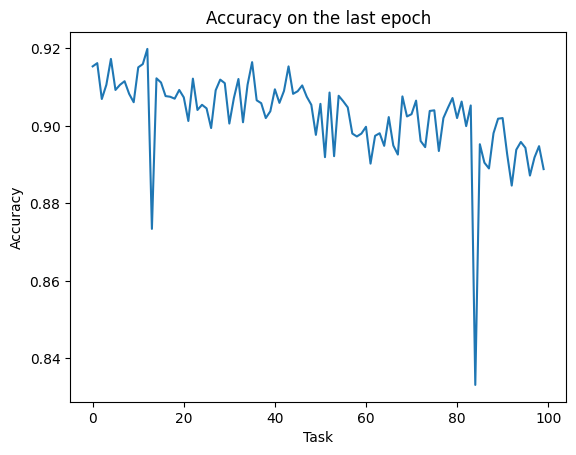

In [26]:
train_data_array = np.array(train_data)
accuracies = train_data_array[:, -1]

with open('permuted_mnist.pkl', 'wb') as f:
    pickle.dump(train_data_array, f)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(accuracies)
ax.set_xlabel('Task')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy on the last epoch')
plt.show()

In [37]:
runs = 3 
# array =  np.empty(len(permuted_datasets))
list = []
for i in range(runs):
  net = FFNet()
  optimizer = torch.optim.SGD(net.parameters(), lr=0.01)
  train_data = train_3(model=net, optimizer=optimizer, datasets=permuted_datasets, loss_fn=cross_entropy, epochs=100)
  list.append(train_data)
  
npa = np.asarray(list, dtype=np.float32)

Dataset 0
Epoch: 0, Loss: 2.7958271503448486, Validation Accuracy: 0.19691666666666666
Epoch: 1, Loss: 2.2053611278533936, Validation Accuracy: 0.33375
Epoch: 2, Loss: 1.9549970626831055, Validation Accuracy: 0.46608333333333335
Epoch: 3, Loss: 1.7439106702804565, Validation Accuracy: 0.5525833333333333
Epoch: 4, Loss: 1.5534323453903198, Validation Accuracy: 0.5995833333333334
Epoch: 5, Loss: 1.393304467201233, Validation Accuracy: 0.6143333333333333
Epoch: 6, Loss: 1.2919460535049438, Validation Accuracy: 0.5690833333333334
Epoch: 7, Loss: 1.3508007526397705, Validation Accuracy: 0.49041666666666667
Epoch: 8, Loss: 1.7055264711380005, Validation Accuracy: 0.48091666666666666
Epoch: 9, Loss: 1.5560224056243896, Validation Accuracy: 0.6466666666666666
Epoch: 10, Loss: 1.1590129137039185, Validation Accuracy: 0.7041666666666667
Epoch: 11, Loss: 0.9932851791381836, Validation Accuracy: 0.7455
Epoch: 12, Loss: 0.887205183506012, Validation Accuracy: 0.7415
Epoch: 13, Loss: 0.8498361706733

In [42]:
npa = np.array(npa)
accuracies = npa[:, :, -1]
accuracies = np.array(accuracies)
# rows iterations, columns tasks

array([[0.90508336, 0.91758335],
       [0.90833336, 0.90466666],
       [0.9069167 , 0.909     ]], dtype=float32)